# Machine Learning
We apply a Random Forest classifier to our timelag and correlation calculations over the whole AR.

In [1]:
import sys

import numpy as np
from scipy.interpolate import splev
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn
import astropy.units as u
from astropy.coordinates import SkyCoord
from sunpy.map import Map,GenericMap
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,scale
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import dask
import distributed
from dask_ml.model_selection import RandomizedSearchCV
from dask_ml.model_selection import train_test_split as dask_train_test_split

from synthesizAR.instruments import InstrumentSDOAIA

sys.path.append('../paper/python/')
from formatting import get_figsize,heating_palette,qualitative_palette,heating_cmap

import warnings
warnings.filterwarnings('ignore',category=UserWarning,)

%matplotlib inline

## Data Prep and Import
First, we need to import all of our timelag and correlation data, both modeled and observed, into data matrices, $X$, $Y$, and $X_{obs}$

In [2]:
heating = ['high_frequency', 'intermediate_frequency', 'low_frequency',]
labels = [h.split('_')[0].capitalize() for h in heating]

In [3]:
channels = [94,131,171,193,211,335]
channel_pairs = [(94,335),
                 (94,171),
                 (94,193),
                 (94,131),
                 (94,211),
                 (335,131),
                 (335,193),
                 (335,211), 
                 (335,171),
                 (211,131),
                 (211,171),
                 (211,193),
                 (193,171),
                 (193,131),
                 (171,131),]

In [11]:
correlation_threshold = 0.1

### Model
First we need to load the training data from our model. This includes the EM slopes, timelags, and cross-correlations.

In [7]:
file_format = '../paper/data/{}/{}_{}_{}.fits'

In [8]:
# Timelags
X_timelag = np.stack([Map(file_format.format(h,'timelag',*cp)).data for h in heating for cp in channel_pairs])

In [10]:
# Correlation
X_correlation = np.stack([Map(file_format.format(h,'correlation',*cp)).data for h in heating for cp in channel_pairs])

In [20]:
correlation_mask = (X_correlation < correlation_threshold).any(axis=0,)

In [23]:
# EM Slopes
X_slopes = np.stack([Map('../paper/data/{}/em_slope.fits'.format(h)).data for h in heating])

In [26]:
slope_mask = np.isnan(X_slopes).any(axis=0)

In [27]:
mask = np.stack((correlation_mask,slope_mask),).any(axis=0)

In [33]:
X_timelag.transpose()

(543, 519, 45)

In [30]:
X_timelag.shape

(45, 519, 543)

In [32]:
np.where(mask)

(array([  0,   0,   0, ..., 518, 518, 518]),
 array([  0,   1,   2, ..., 540, 541, 542]))

In [6]:
X_timelag,X_correlation,Y = None,None,None
for i,h in enumerate(heating):
    _X_correlation,_X_timelag = None,None
    # Find the indices where all channel pairs have an acceptable correlation
    acceptable = np.all(np.stack([Map(file_format.format(h,'correlation',*cp)).data 
                                  for cp in channel_pairs], axis=2) > correlation_threshold, axis=2)
    i_accept = np.where(acceptable)
    for cp in channel_pairs:
        # Read in timelags
        # Only keep those timelags with sufficiently high correlations
        tmp_tl = Map(file_format.format(h,'timelag',*cp)).data[i_accept].flatten()
        # Stack along columns for different channel pairs
        _X_timelag = tmp_tl.copy()[:, np.newaxis] if _X_timelag is None else np.hstack([_X_timelag, tmp_tl[:, np.newaxis]])
        # Read in correlations
        tmp_tl = Map(file_format.format(h,'correlation',*cp)).data[i_accept].flatten()
        # Stack along columns for different channel pairs
        _X_correlation = tmp_tl.copy()[:, np.newaxis] if _X_correlation is None else np.hstack([_X_correlation, tmp_tl[:, np.newaxis]])
    # Stack along rows for different frequencies
    X_timelag = _X_timelag.copy() if X_timelag is None else np.vstack([X_timelag, _X_timelag])
    X_correlation = _X_correlation.copy() if X_correlation is None else np.vstack([X_correlation, _X_correlation])
    # Get the frequency labels
    _Y = np.array(_X_timelag.shape[0]*[labels[i]])
    Y = _Y.copy() if Y is None else np.concatenate([Y, _Y])

We now encode each label with a numerical value in order to apply our classification method. We use the following scheme,

* High frequency $\to$ 0
* Intermediate frequency $\to$ 1
* Low frequency $\to$ 2

In [8]:
# Numerically encode frequency
le = LabelEncoder()
le.fit(labels)
Y_encoded = le.transform(Y)

In [9]:
Y_encoded

array([0, 0, 0, ..., 2, 2, 2])

In [10]:
Y

array(['High', 'High', 'High', ..., 'Low', 'Low', 'Low'], dtype='<U12')

Finally, we scale the data matrix $\mathbf{X}$ such that,

$$
\mathbf{X} \to \frac{\mathbf{X} - \bar{\mathbf{X}}}{\sigma_{\mathbf{X}}}
$$

where we apply this operation down each column.

In [11]:
X_scaled = scale(np.hstack([X_timelag,X_correlation],),axis=0, with_mean=True, with_std=True,)

Additionally, we perform a $2/3,1/3$ train/test split on the data.

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_encoded, test_size=0.33)

Note that our training and test data matrices include both the timelags (columns 0-14) and the cross-correlation values (15-29).

### Observations

Next, we import the observational data and again shape it into our data matrix $\mathbf{X}_{obs}$.

In [13]:
file_format = '/storage-home/w/wtb2/data/timelag_synthesis_v2/observational_data/timelags/{}_{}_{}.fits'

In [14]:
# Find the indices where all channel pairs have an acceptable correlation
acceptable_correlation = np.all(np.stack([Map(file_format.format('correlation',*cp)).data
                                          for cp in channel_pairs], axis=2) > correlation_threshold, axis=2)
i_accept_obs = np.where(acceptable_correlation)
# Stack maps
X_observation_timelag,X_observation_correlation = None,None
for cp in channel_pairs:
    # Read in timelags
    # Only keep those timelags with sufficiently high correlations
    tmp_tl = Map(file_format.format('timelag', *cp)).data[i_accept_obs].flatten()
    # Stack along columns for different channel pairs
    X_observation_timelag = tmp_tl.copy()[:,np.newaxis] if X_observation_timelag is None else np.hstack([X_observation_timelag, tmp_tl[:, np.newaxis]])
    # Read in correlation
    tmp_tl = Map(file_format.format('correlation', *cp)).data[i_accept_obs].flatten()
    # Stack along columns for different channel pairs
    X_observation_correlation = tmp_tl.copy()[:,np.newaxis] if X_observation_correlation is None else np.hstack([X_observation_correlation, tmp_tl[:, np.newaxis]])
# Scale data
X_observation = scale(np.hstack([X_observation_timelag,X_observation_correlation]),axis=0, with_mean=True, with_std=True)

## Classification

Now, we train a Random Forest classifier on our model results.

### Base Model
To start off with, we'll choose a set of parameters that sound the best and we'll run the classifier.

In [34]:
rf_options = {
    'n_estimators': 100,
    'max_features': 'sqrt',
    'criterion': 'entropy',
    'max_depth': 25,
    'min_samples_leaf': 1,
    'bootstrap': True,
    'oob_score': True,
}

In [35]:
clf = RandomForestClassifier(**rf_options)

In [36]:
clf.fit(X_train[:,[i for i in range(30) if i != 26 and i != 11]],Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=25, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [37]:
print(f'Test error = {1. - clf.score(X_test[:,[i for i in range(30) if i != 26 and i != 11]],Y_test)}')

Test error = 0.03795589048389414


This seems to do quite well. However, we should consider a range of hyper parameters before definitely settling on these.

### Cross-validation via Random Grid Search

In [15]:
grid_parameters = {
    'n_estimators': [10, 100, 200],
    'max_features': ['sqrt', 1/3],
    'max_depth': [10, 20, 50],
    'min_samples_leaf': [1],
    'criterion': ['entropy','gini'],
    'bootstrap': [True,],
    'oob_score': [True, False],
}

In [16]:
rf = RandomForestClassifier()

In [17]:
client = distributed.Client()

In [18]:
client

Client Scheduler: tcp://127.0.0.1:32827 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 64 Cores: 64 Memory: 270.38 GB


In [19]:
clf_rcv = RandomizedSearchCV(rf, grid_parameters, n_iter=100,)

In [32]:
X_train_dask, X_test_dask, Y_train_dask, Y_test_dask = dask_train_test_split(
    dask.array.from_array(X_scaled,chunks=X_scaled.shape),
    dask.array.from_array(Y_encoded,chunks=Y_encoded.shape),
    test_size=0.33,
)

In [33]:
clf_rcv.fit(X_train_dask, Y_train_dask)

RandomizedSearchCV(cache_cv=True, cv=None, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [10, 100, 200], 'max_features': ['sqrt', 0.3333333333333333], 'max_depth': [10, 20, 50], 'min_samples_leaf': [1], 'criterion': ['entropy', 'gini'], 'bootstrap': [True], 'oob_score': [True, False]},
          random_state=None, refit=True, return_train_score='warn',
          scheduler=None, scoring=None)

In [38]:
clf_rcv.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=50, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

## Application to Observations

And then apply our trained model to our unlabeled observational data, computing both the label and the probability.

In [38]:
Y_observation = clf.predict(X_observation[:,[i for i in range(30) if i != 26 and i != 11]])

In [39]:
Y_observation_prob = clf.predict_proba(X_observation[:,[i for i in range(30) if i != 26 and i != 11]])

In the last step, we want to transform these predicted data matrices back into maps of the active region. We do this for both the labeled frequencies as well as the probabilities. 

In [40]:
dummy = Map(file_format.format('timelag', *channel_pairs[0]))

In [41]:
probability_maps = {}
for i,h in enumerate(labels):
    tmp = dummy.data.copy() * np.nan
    # Only those which we selected to classify originally are not NaN
    i_select = np.where(le.inverse_transform(clf.classes_) == h)[0][0]
    tmp[i_accept_obs] = Y_observation_prob[:, i_select]
    probability_maps[h] = GenericMap(tmp, dummy.meta)

In [42]:
tmp = dummy.data.copy() * np.nan
tmp[i_accept_obs] = Y_observation
frequency_map = GenericMap(tmp, dummy.meta)

## Figure Code
Make sure not to remove this

Finally, make plots of both the frequency label as well as the probabilites of each class.

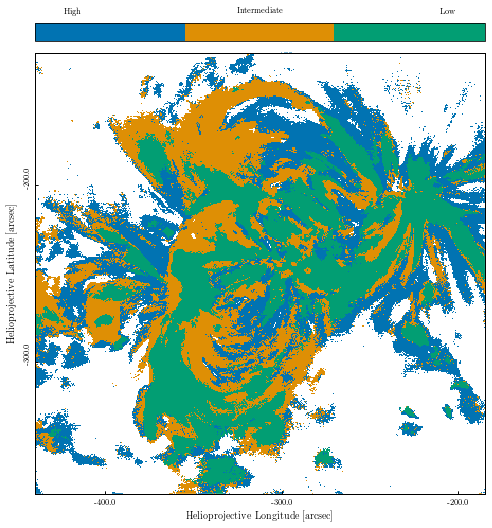

In [44]:
fig = plt.figure(figsize=get_figsize(wf=1.85,))
cax = fig.add_axes([0.275, 0.9, 0.475, 0.03])
m = frequency_map.submap(SkyCoord(Tx=-440*u.arcsec,Ty=-380*u.arcsec,frame=frequency_map.coordinate_frame),
                         SkyCoord(Tx=-185*u.arcsec,Ty=-125*u.arcsec,frame=frequency_map.coordinate_frame))
ax = fig.gca(projection=m)
im = m.plot(
    axes=ax,
    title=False,
    annotate=False,
    vmin=-0.5,
    vmax=2.5,
    cmap=heating_cmap()
)
ax.grid(alpha=0)
# Axes and ticks
lon, lat = ax.coords
lon.set_ticklabel(fontsize=plt.rcParams['xtick.labelsize'],)
lat.set_ticklabel(fontsize=plt.rcParams['ytick.labelsize'], rotation='vertical')
lon.set_axislabel('Helioprojective Longitude [arcsec]', fontsize=plt.rcParams['axes.labelsize'])
lat.set_axislabel('Helioprojective Latitude [arcsec]', fontsize=plt.rcParams['axes.labelsize'])
lon.set_ticks(number=3)
lat.set_ticks(number=3)
# Colorbar
cbar = fig.colorbar(im, cax=cax,orientation='horizontal')
cbar.ax.xaxis.set_ticks_position('top')
cbar.set_ticks([-0.25,1,2.25])
cbar.ax.set_xticklabels(labels,)
cbar.ax.tick_params(axis='x',which='both',length=0)
#fig.savefig('../paper/figures/frequency_map.pdf')

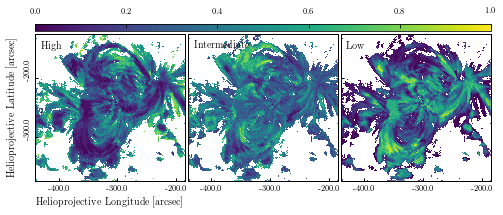

In [45]:
fig = plt.figure(figsize=get_figsize(wf=1.15,hf=0.375))
cax = fig.add_axes([0.125, 0.85, 0.775, 0.03])
for i,h in enumerate(labels[:3]):
    m = probability_maps[h]
    m = m.submap(SkyCoord(Tx=-440*u.arcsec,Ty=-380*u.arcsec,frame=m.coordinate_frame),
                 SkyCoord(Tx=-185*u.arcsec,Ty=-125*u.arcsec,frame=m.coordinate_frame))
    ax = fig.add_subplot(1,3,i+1, projection=m)
    im = m.plot(axes=ax,
                annotate=False,
                title=False,
                vmin=0,
                vmax=1,
                cmap='viridis',
               )
    ax.grid(alpha=0)
    lon,lat = ax.coords
    lon.set_ticks(number=3)
    lat.set_ticks(number=3)
    lon.set_ticklabel(fontsize=plt.rcParams['xtick.labelsize'])
    if i > 0:
        lat.set_ticklabel_visible(False)
    else:
        lat.set_ticklabel(fontsize=plt.rcParams['ytick.labelsize'], rotation='vertical')
    if i == 0:
        lon.set_axislabel('Helioprojective Longitude [arcsec]', fontsize=plt.rcParams['axes.labelsize'])
        lat.set_axislabel('Helioprojective Latitude [arcsec]', fontsize=plt.rcParams['axes.labelsize'])
    xtext,ytext = m.world_to_pixel(SkyCoord(-430*u.arcsec,-150*u.arcsec,frame=m.coordinate_frame))
    xtext,ytext = int(xtext.value), int(ytext.value)
    ax.text(xtext, ytext, h, color='k', fontsize=plt.rcParams['axes.labelsize'])
cbar = fig.colorbar(im, cax=cax, orientation='horizontal')
cbar.ax.xaxis.set_ticks_position('top')
plt.subplots_adjust(wspace=0.02)
#fig.savefig('../paper/figures/probability_maps.pdf')

For this combined case, let's plot the importance of each of the features in performing the classification in each pixel

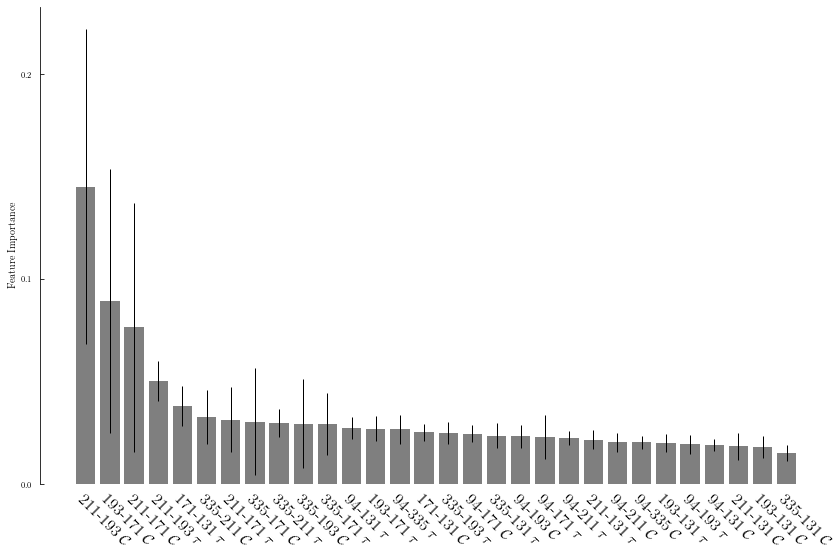

In [27]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
est_std = np.std([t.feature_importances_ for t in clf.estimators_], axis=0)
fig = plt.figure(figsize=get_figsize(wf=2))
ax = fig.gca()
ax.bar(range(X_train.shape[1]), importances[indices], yerr=est_std[indices], color='k', align='center',alpha=0.5)
#ax.set_ylim(0,0.2)
ax.set_xticks(range(X_train.shape[1]),);
all_labs = (
    ['{}-{} $\\tau$'.format(*cp) for cp in channel_pairs] +
    ['{}-{} $\mathcal{{C}}$'.format(*cp) for cp in channel_pairs])
ax.set_xticklabels(np.array(all_labs)[indices],fontsize=16);
plt.setp(ax.xaxis.get_majorticklabels(), rotation=-45, ha="left", rotation_mode='anchor');
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_bounds(ax.get_ylim()[1], ax.get_ylim()[-2])
ax.xaxis.set_tick_params(length=0)
ax.set_ylabel('Feature Importance')
ax.set_yticks(ax.get_yticks()[::2]);